In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, BatchNormalization, LeakyReLU
from tensorflow.keras import Sequential, Model
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
%matplotlib inline

/home/ninja/anaconda3/envs/DS1_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ninja/anaconda3/envs/DS1_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ninja/anaconda3/envs/DS1_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ninja/anaconda3/envs/DS1_env/lib/python3

In [2]:
TRAIN_DATA_PATH = 'data_300_samples200000.npz'

In [3]:
class TandemModel:
    SAMPLE_SIZE = 300
    NETA_RANGE = (0.7, 0.9)
    DELTA_RANGE = (0.08, 0.1)
    N_RANGE = (200, 300)
    PITCH_RANGE = (200, 300)
    LAMBDA_MAX_RANGE = (1500, 2500)
    LAMBDA_RANGE = (500, 3500)
    NO_OF_VARIABLES = 5
    
    
    def __init__(self, path_to_data):
        self.path = path_to_data
        self.x_train = None
        self.y_train = None
        self.x_test = None
        self.y_test = None
        
        # load data
        with np.load(self.path) as data:
            self.x_train, self.x_test, self.y_train, self.y_test = data['Xtrain'], data['Xtest'], data['Ytrain'], data['Ytest']
            
        self.fwd_input_shape = self.x_train.shape[1:]
        self.fwd_ouput_units = self.y_train.shape[1]
        
        self.bwd_input_shape = self.y_train.shape[1:]
        self.bwd_output_units = self.x_train.shape[1]
        
        self.fwd = None
        self.bwd = None
        self.tandem = None
        
        # A-law parameter
        self.A = 87.7
        # mu-law parameter
        self.mu = 255

    def apply_non_linear(self, law='A'):
        self.y_train = self.non_linear_filter(self.y_train, law)
        self.y_test = self.non_linear_filter(self.y_test, law)
    
    def P(neta, delta, N, pitch, x, x0):
        """
        Reflected power function
        """
        sqrt = lambda v: complex(v, 0)**0.5

        g = (1.0/(neta*delta))*((x/x0)-1)
        g = g**2

        theta = neta*delta*N*pitch*sqrt(1-g)/x

        nr = sinh(theta)**2
        dr = (cosh(theta)**2)-g

        return abs(nr/dr)


    def reflected_samples(neta:float, delta:float, N:float, pitch:float, x0:float):
        """
        returns : numpy array 
        """

        # uniformly sample the function
        # generate sample points
        d = (LAMBDA_RANGE[1] - LAMBDA_RANGE[0])/SAMPLE_SIZE
        x = LAMBDA_RANGE[0]

        Y = []

        for _ in range(SAMPLE_SIZE):
            Y.append(P(neta, delta, N, pitch, x, x0))
            x = x + d

        return np.array(Y)
    
    def non_linear_filter(self, x, law='A'):
        if law == 'A':
            return (1+np.log(self.A*x))/(1+np.log(self.A))
        else:
            return np.log(1+self.mu*x)/np.log(1+self.mu)
        
    def inverse(self, x, law='A'):
        if law == 'A':
            return np.exp(x*(1+np.log(self.A))-1)/self.A
        else:
            return ((1+self.mu)**x - 1)/self.mu
    
    
    def build_fwd_model(self):
        """
        predicts target response based on design parameters
        """
        self.fwd = Sequential(name='fwd_model')
        
        inputs = Input(shape=self.fwd_input_shape, name='fwd_input_layer')
        
        x = Dense(256, activation='relu', name='layer1')(inputs)
        x = BatchNormalization()(x)
        x = Dense(256, activation='relu', name='layer2')(x)
        x = BatchNormalization()(x)
        x = Dense(256, activation='relu', name='layer3')(x)
        x = BatchNormalization()(x)
        x = Dense(256, activation='relu', name='layer4')(x)
        x = BatchNormalization()(x)
        
        outputs = Dense(self.fwd_ouput_units, name='fwd_output_layer', activation='sigmoid')(x)

        self.fwd = Model(inputs=inputs, outputs=outputs)

    
    def load_fwd_saved_model(self, path):
        self.fwd = load_model(path)
        
    
    def build_bwd_model(self):
        """
        predicts design parameters based on target response
        """
        inputs = Input(shape=self.bwd_input_shape, name='bwd_input_layer')
        
        x = Dense(64, activation='relu', name='bwd_hidden_layer1')(inputs)
        x = BatchNormalization()(x)
        x = Dense(64, activation='relu', name='bwd_hidden_layer2')(x)
        x = BatchNormalization()(x)
        x = Dense(64, activation='relu', name='bwd_hidden_layer3')(x)
        x = BatchNormalization()(x)
        x = Dense(32, activation='relu', name='bwd_hidden_layer4')(x)
        x = BatchNormalization()(x)
        x = Dense(self.bwd_output_units, name='bwd_output_layer', activation='sigmoid')(x)
        
        self.bwd = Model(inputs, x)
    

    def build_tandem_model(self):
        x = self.bwd.output
        
        for layer in self.fwd.layers[1:]:
            layer.trainable = False
            x = layer(x)
            
        self.tandem = Model(inputs=self.bwd.input, outputs=x)
        
    
    def load_bwd_saved_model(self, path):
        self.bwd = load_model(path)
    
    
    def summary(self, model='fwd'):
        if(model == 'fwd'):
            return self.fwd.summary()
        return self.bwd.summary()
    
    
    def fit_fwd(self, batch_size=64, epochs=5, validation_split=0.2):
        return self.fwd.fit(self.x_train, self.y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, shuffle=True)
        
    
    def save_model(self, path, model='fwd'):
        if model == 'fwd':
            self.fwd.save(path)
        else:
            self.bwd.save(path)
    
    def plot(self, history):
        plt.plot(history.epoch, history.history['accuracy'])
        plt.plot(history.epoch, history.history['loss'])
        plt.xlabel('epochs')
        plt.legend(['accuracy', 'loss'], loc='upper left')
    

In [4]:
tandem = TandemModel(TRAIN_DATA_PATH)

In [5]:
print((tandem.fwd_input_shape, tandem.fwd_ouput_units), (tandem.bwd_input_shape, tandem.bwd_output_units))

((5,), 300) ((300,), 5)


In [12]:
# train fwd model
filtered = False
tandem.build_fwd_model()
# tandem.apply_non_linear('A')
tandem.summary()
tandem.fwd.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
tandem.fit_fwd(batch_size=256, epochs=100, validation_split=0.002)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fwd_input_layer (InputLayer) [(None, 5)]               0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               1536      
_________________________________________________________________
batch_normalization_12 (Batc (None, 256)               1024      
_________________________________________________________________
dense_13 (Dense)             (None, 256)               65792     
_________________________________________________________________
batch_normalization_13 (Batc (None, 256)               1024      
_________________________________________________________________
dense_14 (Dense)             (None, 256)               65792     
_________________________________________________________________
batch_normalization_14 (Batc (None, 256)               1024

128000/128000 [==============================] - 6s 47us/sample - loss: 1.5209e-04 - acc: 0.1849 - val_loss: 1.0640e-04 - val_acc: 0.2225
Epoch 99/100
128000/128000 [==============================] - 6s 47us/sample - loss: 1.4907e-04 - acc: 0.1849 - val_loss: 1.0808e-04 - val_acc: 0.2162
Epoch 100/100
128000/128000 [==============================] - 6s 47us/sample - loss: 1.5105e-04 - acc: 0.1854 - val_loss: 1.4747e-04 - val_acc: 0.2108


TypeError: 'XAxis' object is not callable

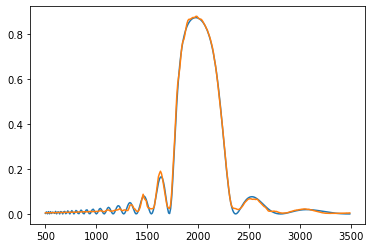

In [36]:
# test fwd model
predictions = tandem.fwd.predict(tandem.x_test)

d = (tandem.LAMBDA_RANGE[1] - tandem.LAMBDA_RANGE[0])/tandem.SAMPLE_SIZE
x = []
start = tandem.LAMBDA_RANGE[0]

for _ in range(tandem.SAMPLE_SIZE):
    x.append(start)
    start = start + d

x = np.array(x)
# plot the predictions
random_samples = [random.randint(0, len(predictions)) for _ in range(50)]
for i in random_samples:
    fig, ax = plt.subplots()
    
    if filtered:
        ax.plot(tandem.inverse(tandem.y_test[i]))
        ax.plot(tandem.inverse(predictions[i]))
    else:
        ax.plot(x, tandem.y_test[i])
        ax.plot(x, predictions[i])
    
    ax.legend(['actual', 'prediction'], loc='upper left')

In [18]:
# save the fwd model
tandem.fwd.save('fwd_256x256x256x256_50epochs_1e-4_adam_200000')

In [19]:
del tandem

tandem = TandemModel(TRAIN_DATA_PATH)
tandem.load_fwd_saved_model('fwd_256x256x256x256_50epochs_1e-4_adam_200000')
tandem.build_bwd_model()
tandem.build_tandem_model()
tandem.bwd.summary()
tandem.fwd.summary()
# tandem.tandem.summary()
tandem.tandem.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bwd_input_layer (InputLayer) [(None, 300)]             0         
_________________________________________________________________
bwd_hidden_layer1 (Dense)    (None, 64)                19264     
_________________________________________________________________
batch_normalization_20 (Batc (None, 64)                256       
_________________________________________________________________
bwd_hidden_layer2 (Dense)    (None, 64)                4160      
_________________________________________________________________
batch_normalization_21 (Batc (None, 64)                256       
_________________________________________________________________
bwd_hidden_layer3 (Dense)    (None, 64)                4160      
_________________________________________________________________
batch_normalization_22 (Batc (None, 64)                256 

In [24]:
history = tandem.tandem.fit(tandem.y_train, tandem.y_train, epochs=20, batch_size=256, validation_split=0.02, shuffle=True)

Train on 156800 samples, validate on 3200 samples
Epoch 1/20
156800/156800 [==============================] - 8s 49us/sample - loss: 6.5632e-04 - acc: 0.1745 - val_loss: 6.6221e-04 - val_acc: 0.2025
Epoch 2/20
156800/156800 [==============================] - 8s 52us/sample - loss: 6.3047e-04 - acc: 0.1784 - val_loss: 6.0150e-04 - val_acc: 0.2075
Epoch 3/20
156800/156800 [==============================] - 8s 53us/sample - loss: 6.1897e-04 - acc: 0.1755 - val_loss: 5.2296e-04 - val_acc: 0.2284
Epoch 4/20
156800/156800 [==============================] - 8s 52us/sample - loss: 5.6579e-04 - acc: 0.1772 - val_loss: 4.0427e-04 - val_acc: 0.2191
Epoch 5/20
156800/156800 [==============================] - 8s 51us/sample - loss: 5.7256e-04 - acc: 0.1767 - val_loss: 3.3605e-04 - val_acc: 0.2131
Epoch 6/20
156800/156800 [==============================] - 8s 49us/sample - loss: 5.3696e-04 - acc: 0.1788 - val_loss: 8.1932e-04 - val_acc: 0.1994
Epoch 7/20
156800/156800 [==============================

In [21]:
tandem.tandem.evaluate(tandem.y_test, tandem.y_test)

40000/40000 [==============================] - 3s 82us/sample - loss: 4.6068e-04 - acc: 0.2281


[0.00046067746004555373, 0.22815]

/home/ninja/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


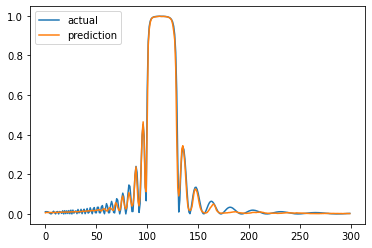

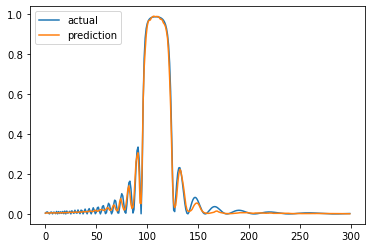

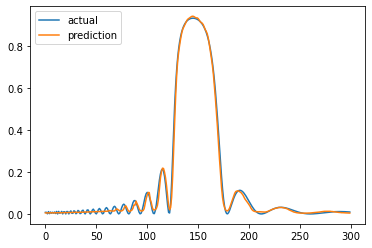

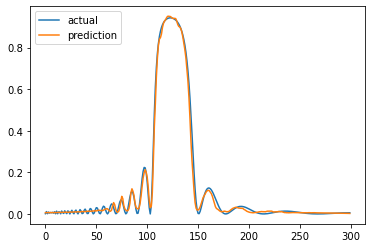

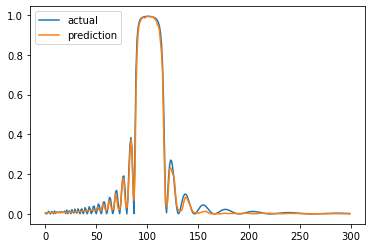

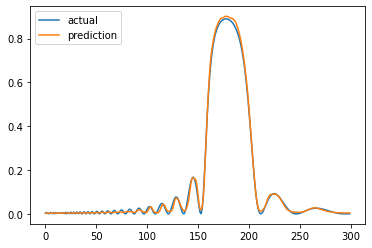

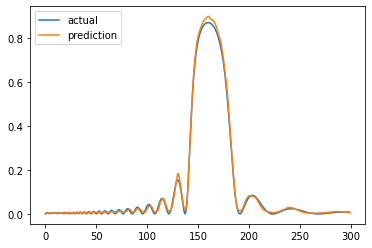

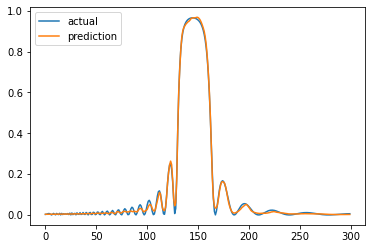

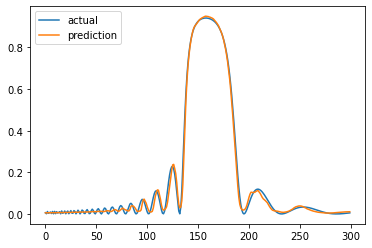

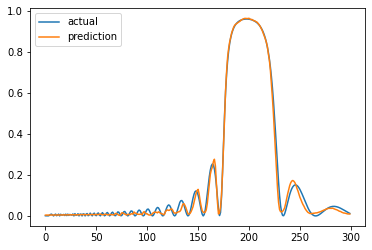

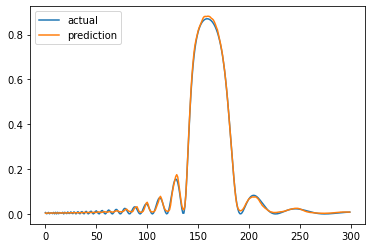

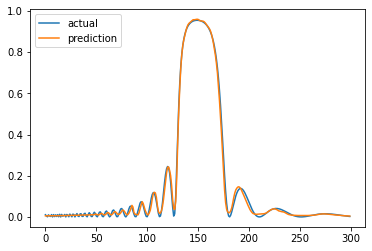

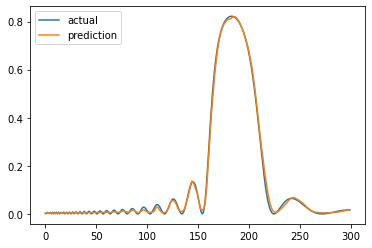

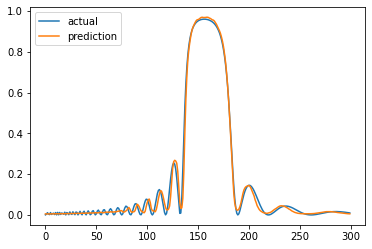

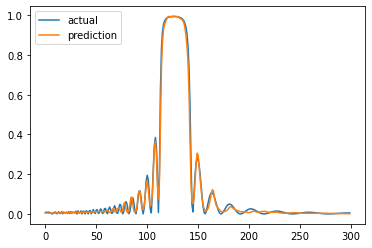

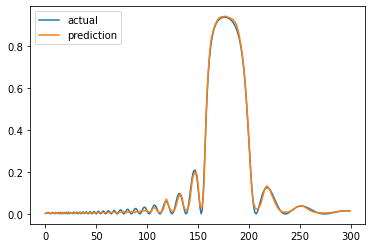

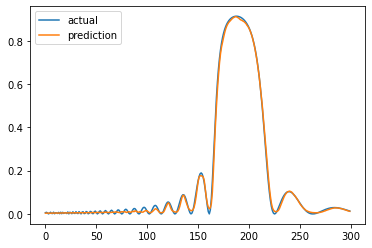

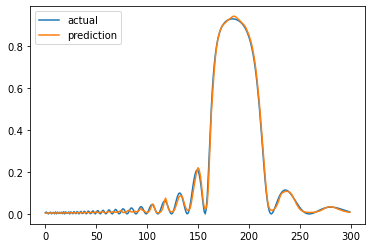

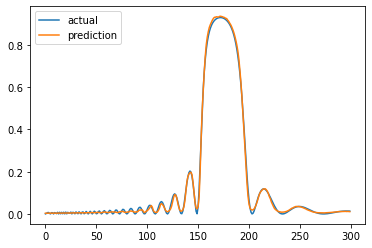

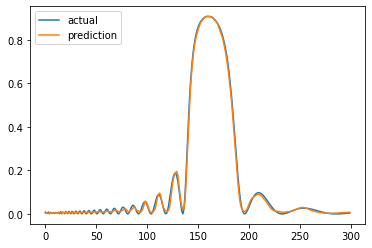

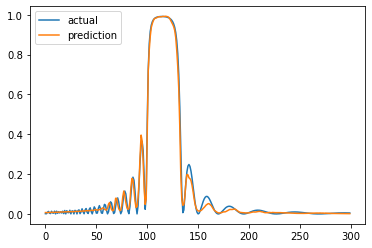

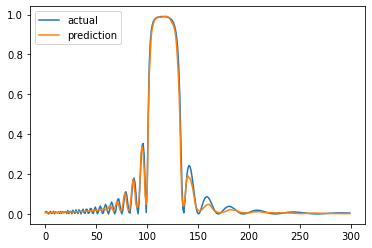

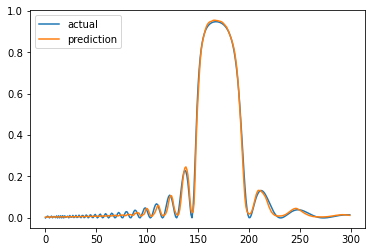

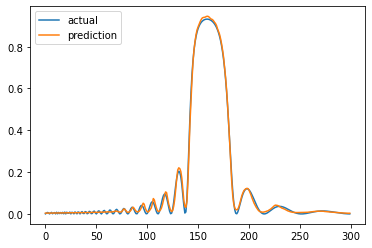

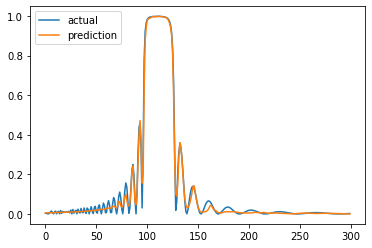

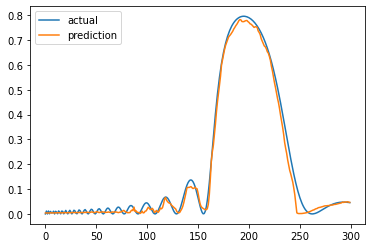

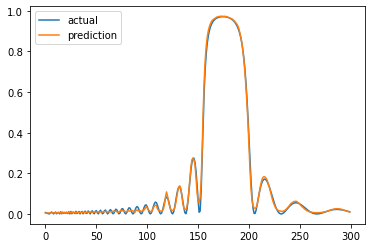

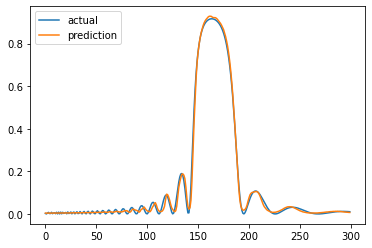

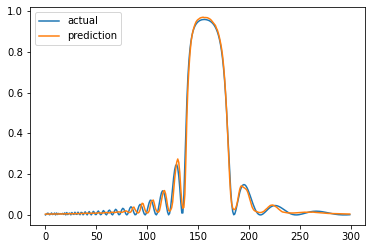

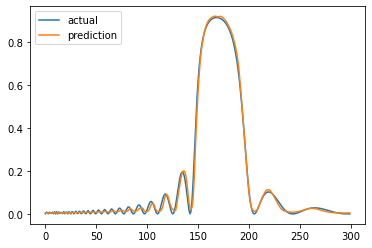

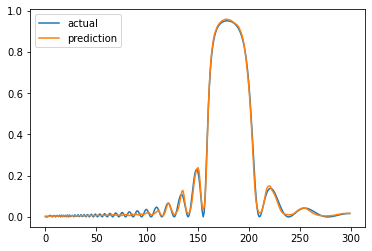

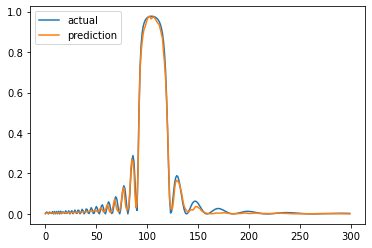

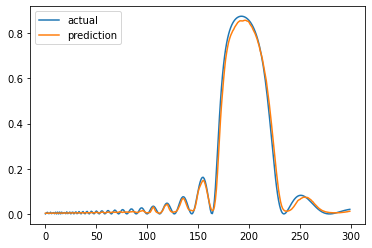

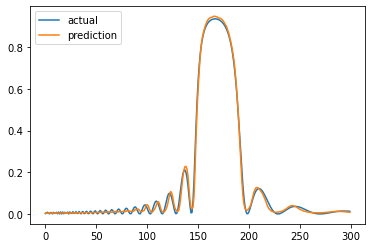

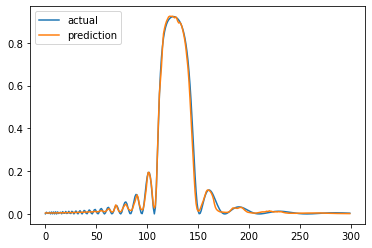

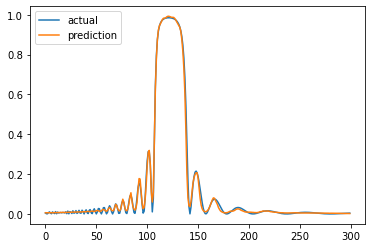

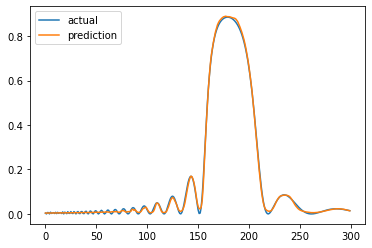

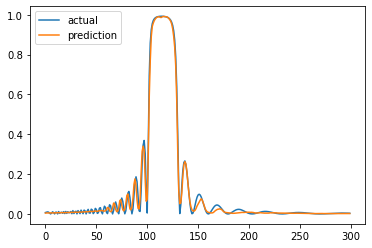

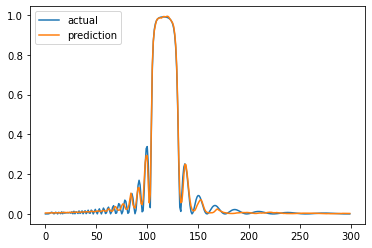

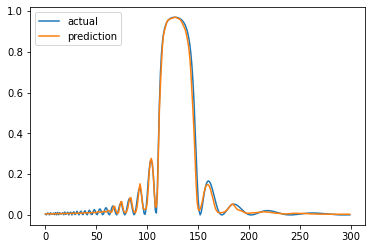

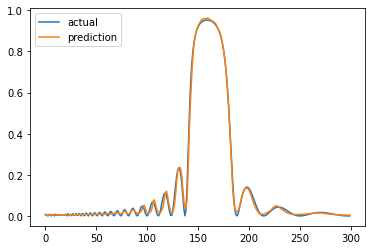

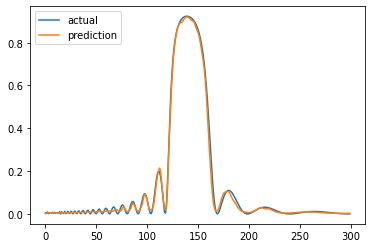

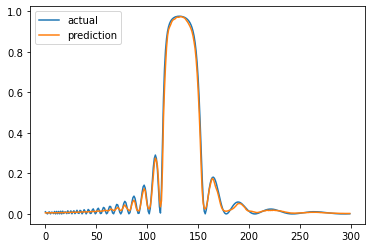

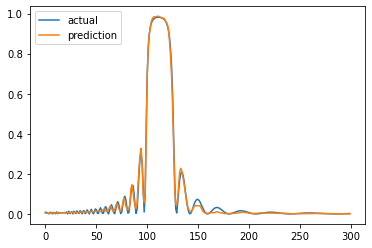

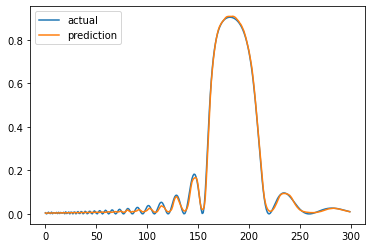

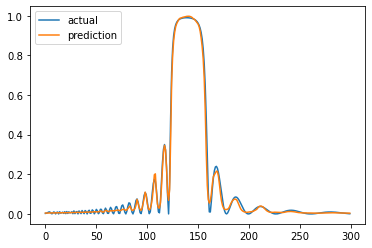

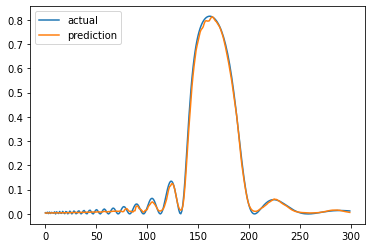

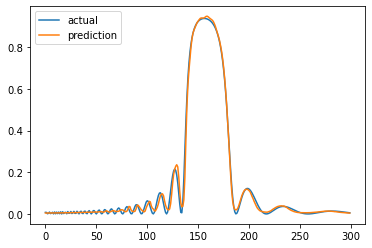

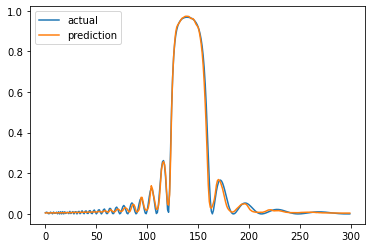

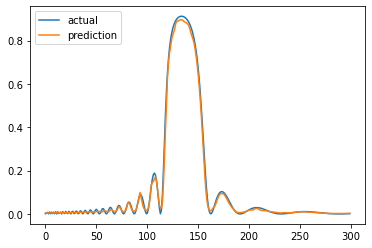

In [25]:
# test on examples
predictions = tandem.tandem.predict(tandem.y_test)
x = 
random_samples = [random.randint(0, len(predictions)) for _ in range(50)]
for i in random_samples:
    fig, ax = plt.subplots()
    
    ax.plot(tandem.y_test[i])
    ax.plot(predictions[i])
    
    ax.legend(['actual', 'prediction'], loc='upper left')
    ax.title('')

In [26]:
# save bwd model
tandem.bwd.save('bwd_64x64x64x32_50epochs_4e-4_adam_200000')

In [27]:
# save tandem model
tandem.tandem.save('tandem_fwd_256x256x256x256_50epochs_1e-4_adam_bwd_64x64x64x32_50epochs_4e-4_adam_200000')

In [6]:
# train model without tandem network
tandem.build_bwd_model()
bwd = tandem.bwd
bwd.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bwd_input_layer (InputLayer) [(None, 300)]             0         
_________________________________________________________________
bwd_hidden_layer1 (Dense)    (None, 64)                19264     
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
bwd_hidden_layer2 (Dense)    (None, 64)                4160      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
bwd_hidden_layer3 (Dense)    (None, 64)                4160      
_________

In [7]:
bwd.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
bwd.fit(tandem.y_train[:100000], tandem.x_train[:100000], epochs=1, batch_size=256, shuffle=True)

100000/100000 [==============================] - 3s 26us/sample - loss: 0.0404 - acc: 0.4447


In [8]:
bwd.save('bwd_without_tandem_64x64x64x32_10epoch_0.0404')